# Winners-Losers


## [Repast for Python (Repast4Py) User Guide](https://repast.github.io/repast4py.site/guide/user_guide.html)

## [API](https://repast.github.io/repast4py.site/apidoc/index.html)

## [GitHub Repast/repast4py](https://github.com/Repast/repast4py)

## [MPI for Python](https://mpi4py.readthedocs.io/en/stable/tutorial.html#collective-communication)


# An idea for the initial example: 

### something close to the *Chakraborti model* in "Winners, Losers" ex. in [Is Inequality Inevitable? (Sc.Am.)](https://www.scientificamerican.com/article/is-inequality-inevitable/). In a closer way, § 2.1 in [Chakraborti, A. (2002). Distributions of money in model markets of economy. International Journal of Modern Physics C, 13(10), 1315-1321](https://arxiv.org/pdf/cond-mat/0205221.pdf). 

ESC $\ell$ set or unset row numbers

(The script in next cell avoids scrolling outputs)

In [1]:
%%javascript
// to avoid scroll in windows
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## -2

MPI and context for everywhere

In [2]:
%%writefile MPIandContext.py

import time
from mpi4py import MPI
from repast4py import context as ctx
import repast4py 
from repast4py import parameters
from repast4py import schedule

# simple debug
from icecream import ic

comm = MPI.COMM_WORLD
rank    = comm.Get_rank()
rankNum = comm.Get_size() #pt

# create the context to hold the agents and manage cross process
# synchronization
context = ctx.SharedContext(comm)

# Initializes the default schedule runner, HERE to create the t() function,
# returning the tick value
"""
init_schedule_runner(comm)
Initializes the default schedule runner, a dynamic schedule of executable 
events shared and synchronized across processes.
Events are added to the scheduled for execution at a particular tick. 
The first valid tick is 0. Events will be executed in tick order, earliest 
before latest. Events scheduled for the same tick will be executed in the 
order in which they were added. If during the execution of a tick, 
an event is scheduled before the executing tick (i.e., scheduled to occur in 
the past) then that event is ignored. The scheduled is synchronized across 
process ranks by determining the global cross-process minimum next scheduled 
event time, and executing only the events schedule for that time. In this way, 
no schedule runs ahead of any other.
"""
runner = schedule.init_schedule_runner(comm)

def t():
    return runner.schedule.tick


# https://repast.github.io/repast4py.site/apidoc/source/repast4py.parameters.html
"""
create_args_parser()
Creates an argparse parser with two arguments: 
1) a yaml format file containing model parameter input, and 
2) an optional json dictionary string that can override that input.
"""
parser = parameters.create_args_parser()

args = parser.parse_args()


"""
init_params(parameters_file, parameters)
Initializes the repast4py.parameters.params dictionary with the model input parameters.
"""
params = parameters.init_params(args.parameters_file, args.parameters)

"""
repast4py.random.default_rng: numpy.random._generator.Generator = Generator(PCG64) 
at 0x7F6812E0CD60 repast4py’s default random generator created using init. 
See the Generator API documentation for more information on the available distributions 
and sampling functions.

Type
numpy.random.Generator

repast4py.random.init(rng_seed=None)
Initializes the default random number generator using the specified seed.

Parameters
rng_seed (int) – the random number seed. Defaults to None in which case, the current 
time as returned by time.time() is used as the seed.
"""

repast4py.random.init(rng_seed=params['myRandom.seed'][rank])
rng = repast4py.random.default_rng 



#timer T()
startTime=-1
def T():
    global startTime
    if startTime < 0:
        startTime=time.time()
    return time.time() - startTime

T()

# count transactions
transactions = 0
def tr(total=False):
    global transactions
    if not total: transactions+=1
    return transactions
    

Overwriting MPIandContext.py


## -1

memory allocations to manage agents

In [3]:
%%writefile memAlloc.py

agent_cache={} # dict with uid as keys and agents' tuples as values, 
               # used by restore_agent (def in classes.py) to avoid rebuild agents
    
ghostsToRequest=[] # list of tuples containing for each ghost the uid and its current rank;
                   # used by the requestGhosts(self) function of the model


Overwriting memAlloc.py


## 0

program starter

In [4]:
%%writefile starter.py

from runMod import *



run(params)

Overwriting starter.py


## 1 

run the model

In [5]:
%%writefile runMod.py

from typing import Dict
from model import *

def run(params: Dict):
    
    model = Model(params) #Model(MPI.COMM_WORLD, params)
    model.start()

Overwriting runMod.py


## 2

classes (agent definitions + restore_agent function)

In [6]:
%%writefile classes.py

from repast4py import core
from typing import Tuple, List

from memAlloc import *
from MPIandContext import *

class WinnerLoser(core.Agent):

    TYPE = 0
    
    def __init__(self, local_id: int, rank: int, wallet: float, counterpartRank: int,\
                myGhostCounterpartId: Tuple, materialWalletValueToBeReported: float):
        super().__init__(id=local_id, type=WinnerLoser.TYPE, rank=rank)

        self.myWallet = wallet

        self.counterpartRank = counterpartRank
        self.counterpartLocalId = -1
        
        self.havePresenceAsSelfOrGhost = [False] * rankNum
        self.havePresenceAsSelfOrGhost[rank] = True
        
        self.myGhostCounterpartId = myGhostCounterpartId
        
        self.materialWalletValueToBeReported = materialWalletValueToBeReported
        
        
    def choosingRankAndCreatingItsGhostIfAny(self) -> List:
        self.counterpartRank = int(rng.integers(0,rankNum))
        if not self.havePresenceAsSelfOrGhost[self.counterpartRank]:
            self.havePresenceAsSelfOrGhost[self.counterpartRank] = True
            return [self.counterpartRank, ((self.uid[0], self.TYPE, rank), rank)]
        
    def operatingInItsRank(self):
        if self.counterpartRank == rank:
            tmpListOfAgentsInTheSameRank = list(context.agents(agent_type=0))
            ii=0
            for i in range(len(tmpListOfAgentsInTheSameRank)):
                if self.uid == tmpListOfAgentsInTheSameRank[i].uid: ii=i
            tmpListOfAgentsInTheSameRank.pop(ii)
            counterpart=tmpListOfAgentsInTheSameRank[int(rng.integers(0,len(tmpListOfAgentsInTheSameRank)))]
            commonWallet = self.myWallet + counterpart.myWallet
            share=float(rng.random())
            self.myWallet = commonWallet*share
            counterpart.myWallet = commonWallet*(1-share)
            tr()
            
        
                              
    def actingAsGhost(self, materialsReadyToExchange):
        if materialsReadyToExchange == []: return #maybe unuseful
        if self.counterpartRank==rank: 
                           # the choice of the WL sending the ghost is to op. here
            materialCounterpart = materialsReadyToExchange.pop(int(rng.integers(0,len(materialsReadyToExchange))))
            commonWallet = self.myWallet + materialCounterpart.myWallet
            share=float(rng.random())
            self.myWallet = commonWallet*share 
                           # the ghost wallet, not relevant
            materialCounterpart.materialWalletValueToBeReported = self.myWallet
                           # the wallet to be reported the WL sending the ghost
            materialCounterpart.myWallet = commonWallet*(1-share)
                           # the counterpart wallet
            tr()
            
            materialCounterpart.myGhostCounterpartId = self.uid
            #print("@@@@@@@", materialCounterpart.myGhostCounterpartId, materialCounterpart)
    
    
    def actingAsReportingGhost(self, materialsToReportTo):
        if materialsToReportTo == []: return #maybe unuseful
        if self.myGhostCounterpartId == (): return #because it is not a reportingGhost(messenger)
        
        notFound = True
        i = 0
        while notFound: 
            if materialsToReportTo[i].uid == self.myGhostCounterpartId:
                #print("FOUND", rank, t(), materialsToReportTo[i].uid,\
                #      self.myGhostCounterpartId, self.materialWalletValueToBeReported,\
                #      self.myWallet, flush =True)
                notFound = False
                materialsToReportTo[i].myWallet = self.materialWalletValueToBeReported
            else: 
                i+=1
                if i == len(materialsToReportTo): return

                
            
    def sendingMyGhostToConcludeTheExchange(self) -> List:

        #return [self.uid[2], (self.uid, self.uid[2])]
        #return [self.myGhostCounterpartId[2], (self.myGhostCounterpartId, self.myGhostCounterpartId[2])]
        return [self.myGhostCounterpartId[2], (self.uid, self.uid[2])]
               # sending a ghost from myself to the rank from where the counterpart ghost
               # was coming

        
     

    def save(self) -> Tuple: # mandatory
        """
        Saves the state of the WinnerLoser as a Tuple.

        Returns:
            The saved state of this WinnerLoser.
        """
        return (self.uid, (self.myWallet, self.counterpartRank, self.myGhostCounterpartId, \
                           self.materialWalletValueToBeReported))

    def update(self, dynState: Tuple): # mandatory
        """
        Updates the state of this agent when it is a ghost
        agent on some rank other than its local one.
        """
        self.myWallet=dynState[0]
        self.counterpartRank = dynState[1]
        self.myGhostCounterpartId = dynState[2]
        self.materialWalletValueToBeReported = dynState[3]

      
            
def restore_agent(agent_data: Tuple):
    
    uid=agent_data[0]

    if uid[1] == WinnerLoser.TYPE:
    
        if uid in agent_cache:   # look for agent_cache in model.py
            tmp = agent_cache[uid] # found
            tmp.myWallet = agent_data[1][0] #restore data
            tmp.counterpartRank = agent_data[1][1]
            tmp.myGhostCounterpartId = agent_data[1][2]
            tmp.materialWalletValueToBeReported = agent_data[1][3]


        else: #creation of an instance of the class with its data
            tmp = WinnerLoser(uid[0], uid[2],agent_data[1][0], agent_data[1][1],\
                             agent_data[1][2], agent_data[1][3])                
            agent_cache[uid] = tmp

        return tmp

    

Overwriting classes.py


## 2b

broadcasting function

In [7]:
%%writefile broadcastF.py

import json
import numpy as np



def countDigits(n):
    count = 0
    while(n>0):
        count+=1
        n=n//10
    return count

def broadcastGhostRequests(mToBcast, params, rankNum, rank, comm, ghostsToRequest):
    
    n=params['WinnerLoser.count'] // rankNum
    countB = 10+n*(22+countDigits(n))
    str_countB="S"+str(countB)
            
    mToBcast=json.dumps(mToBcast)
    mToBcast=np.array(mToBcast, dtype=str_countB) 
    mToBcast=mToBcast.tobytes()    
        
    data=[""]*rankNum
    for k in range(rankNum):
        if rank == k:
            data[k] =mToBcast
        else:
            data[k] = bytearray(countB) 
    for k in range(rankNum):
        comm.Bcast(data[k], root=k)

    for k in range(rankNum):
        data[k]=data[k].decode().rstrip('\x00')

    for k in range(rankNum):
        data[k]=json.loads(data[k])
            

    for anItem in data:
        anItem.pop(0)
        for aSubitem in anItem: 
            if len(aSubitem)>1 and aSubitem[0]==rank: 
                aaSubitem = aSubitem[1][0]
                aaSubitem = tuple(aaSubitem)
                aSubitem=(aSubitem[0], (aaSubitem, aSubitem[1][1]))
                    
                if not tuple(aSubitem[1]) in ghostsToRequest:
                    ghostsToRequest.append(tuple(aSubitem[1]))
                    

Overwriting broadcastF.py


## 3

the model

In [8]:
%%writefile model.py

#from mpi4py import MPI
from MPIandContext import *
from typing import Dict
#from repast4py import schedule
#from repast4py import context as ctx
import repast4py
import json
import csv
import numpy as np
from classes import *
from memAlloc import *
from broadcastF import *



class Model:
    """
    The Model class encapsulates the simulation, and is
    responsible for initialization (scheduling events, creating agents,
    and the grid the agents inhabit IF ANY), and the overall iterating
    behavior of the model.

    Args:
        params: the simulation input parameters
    """
    
    global params
    PARAMS = params
    
    def __init__(self, params: Dict):
        
        self.mToBcast = []
        
        # the context to hold the agents and manage cross process synchronization
        # is created in step -2

        
        # the runner, implementing the schedule, is created in step -2
        # https://repast.github.io/repast4py.site/apidoc/source/repast4py.schedule.html
        
        """
        schedule_repeating_event(at, interval, evt)
        Schedules the specified event to execute at the specified tick, and repeat at 
        the specified interval.

        Parameters
        at (float) – the time of the event.
        interval (float) – the interval at which to repeat event execution.
        evt (Callable) – the Callable to execute when the event occurs.

            A callable is anything that can be called.
            The built-in callable (PyCallable_Check in objects.c) checks if the argument 
            is either:
                an instance of a class with a __call__ method or
                is of a type that has a non null tp_call (c struct) member which 
                indicates callability otherwise (such as in functions, methods etc.)
        """
        runner.schedule_repeating_event(0,    1, self.counter)
        runner.schedule_repeating_event(0.1,  1, self.agentsChoosingCounterpart)
        runner.schedule_repeating_event(0.11, 1, self.agentsSendingTheirGhosts)      
        runner.schedule_repeating_event(0.12, 1, self.agentsExchangingInTheirRanks)
        runner.schedule_repeating_event(0.2,  1, self.sync)
        runner.schedule_repeating_event(0.21, 1, self.ghostsExchangingInDifferentRanks)
        runner.schedule_repeating_event(0.22, 1,\
                                  self.agentsHavingExchangedWithGhostsPreparingTheirOwnGhosts)
        runner.schedule_repeating_event(0.23, 1, self.agentsSendingTheirGhosts)
        runner.schedule_repeating_event(0.24, 1, self.messengerGhostsReportingOccuredExchanges)
        """
        schedule_stop(at)
        Schedules the execution of this schedule to stop at the specified tick.

        Parameters
        at (float) – the tick at which the schedule will stop.
        """
        runner.schedule_stop(params['stop.at'])
        
        runner.schedule_end_event(self.finish)
        

        
        # create agents
        # winnerLoser agents
        
        for i in range(params['WinnerLoser.count'] // rankNum): 
                                                #to subdivide the total #pt
            # create and add the agent to the context
            aWallet=1 #10 * rng.random()
            aWinnerLoser = WinnerLoser(i,rank,aWallet,-1,(), 0)
            context.add(aWinnerLoser)
        
            

        
    def counter(self):
        if int(t()) % 100 == 0: print("rank", rank, "tick", t(), flush=True)
    
    def agentsChoosingCounterpart(self):        
        
        del self.mToBcast 
        self.mToBcast = [rank] 
        
        """
        agents(agent_type=None, count=None, shuffle=False)
        Gets the agents in this SharedContext, optionally of the specified type, count 
        or shuffled.

        Parameters
        agent_type (int) – the type id of the agent, defaults to None.
        count (int) – the number of agents to return, defaults to None, meaning return 
        all the agents.shuffle (bool) – whether or not the iteration order is shuffled.
        If true, the order is shuffled. If false, the iteration order is the order of 
        insertion.

        Returns
        An iterable over all the agents in the context. If the agent_type is 
        not None then an iterable over agents of that type will be returned.

        Return type
        iterable 
        pt addendum: it is a generator, not a list
        """
        
        for aWinnerLoser in context.agents(agent_type=0):
            aRequest = aWinnerLoser.choosingRankAndCreatingItsGhostIfAny()
            if aRequest != None: self.mToBcast.append(aRequest)
    
        #print(self.mToBcast, "£££££££££££££££££", rank, t(), flush = True)
        
        
        
    def agentsSendingTheirGhosts(self):
        if not (params['rank_interaction'] or rankNum==1): return     

        broadcastGhostRequests(self.mToBcast, Model.PARAMS, rankNum, rank, comm, ghostsToRequest)  #broadcasting
        
        """
        https://repast.github.io/repast4py.site/apidoc/source/repast4py.context.html
        request_agents(requested_agents, create_agent)
        Requests agents from other ranks to be copied to this rank as ghosts.

        !!!! This is a collective operation and all ranks must call it, regardless 
        of whether agents are being requested by that rank. The requested agents 
        will be automatically added as ghosts to this rank.

        Parameters
        requested_agents (List) – A list of tuples specifying requested 
        agents and the rank to request from. Each tuple must contain the agents 
        unique id tuple and the rank, for example ((id, type, rank), requested_rank).

        create_agent (Callable) – a Callable that can take the result of an agent 
        save() and return an agent.

        Returns
        ***The list of requested agents.

        Return type
        List[_core.Agent]
        """

        context.request_agents(ghostsToRequest,restore_agent)
        #ic(t(),rank,ghostsToRequest,agent_cache);

        
    def agentsExchangingInTheirRanks(self):
        for aWinnerLoser in context.agents(agent_type=0):
            aWinnerLoser.operatingInItsRank()
  
   
    
    def ghostsExchangingInDifferentRanks(self):          
        if not (params['rank_interaction'] or rankNum==1): return     
        # clean preios initilizations in materials and ghosts
        for aWinnerLoser in context.agents(agent_type=0):
            aWinnerLoser.myGhostCounterpartId = ()
        if not agent_cache == {}:
            currentGhostList=list(agent_cache.keys())
            for i in range(len(agent_cache)):                
                agent_cache[currentGhostList[i]].myGhostCounterpartId = ()

        
        del self.mToBcast 
        self.mToBcast = [rank] 
        
        materialsReadyToExchange = list(context.agents(agent_type=0)).copy()     
        if not agent_cache == {}:
            currentGhostList=list(agent_cache.keys())
            for i in range(len(agent_cache)):                
                agent_cache[currentGhostList[i]].actingAsGhost(materialsReadyToExchange)
       
    
    #preparing mToBcast
    def agentsHavingExchangedWithGhostsPreparingTheirOwnGhosts(self):
        if not (params['rank_interaction'] or rankNum==1): return
        for aWinnerLoser in context.agents(agent_type=0):
            if aWinnerLoser.myGhostCounterpartId != ():
                aRequest = aWinnerLoser.sendingMyGhostToConcludeTheExchange()
                if aRequest != None: self.mToBcast.append(aRequest)
        #print(self.mToBcast, "$$$$$$$$$$$$$$$$$", rank, t(), flush = True)
        
    
    def messengerGhostsReportingOccuredExchanges(self):
        if not (params['rank_interaction'] or rankNum==1): return
        
        
        materialsToReportTo = list(context.agents(agent_type=0)).copy()     
        if not agent_cache == {}:
            currentReportingGhostList=list(agent_cache.keys())
            for i in range(len(agent_cache)):                
                agent_cache[currentReportingGhostList[i]].actingAsReportingGhost(materialsToReportTo)
    

                    
        
    def sync(self):
        """
        synchronize(restore_agent, sync_ghosts=True)
        Synchronizes the model state across processes by moving agents, 
        filling projection buffers with ghosts, updating ghosted state and so forth.

        Parameters
        restore_agent (Callable) – a calluable that takes agent state data and returns 
        an agent instance from that data. The data is a tuple whose first element 
        is the agent’s unique id tuple, and the second element is the agent’s state, 
        as returned by that agent’s type’s save() method.

        sync_ghosts (bool) – if True, the ghosts in any SharedProjections and 
        value layers associated with this SharedContext are also synchronized. 
        Defaults to True.
        """
        context.synchronize(restore_agent)
        #ic(t(),rank,"synchronisation made");
    
                        
    def finish(self):
        allTheWallets = []
        for aWinnerLoser in context.agents(agent_type=0):
            allTheWallets.append(aWinnerLoser.myWallet)
        
        print("\n\nBye bye by rank",rank,"at tick",t(),"clock",T(),\
              "transaction #", tr(True), flush=True)
        #print(allTheWallets, flush = True)
        
        with open(params["log_file_root"]+str(rank)+'.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(allTheWallets)
                
        
    def start(self):
        runner.execute()
        

Overwriting model.py


# Execution

In [9]:
# R U N
# %sx mpirun -n 1 python3 starter.py winners-losers.yaml
! mpirun -n 3 python3 starter.py winners-losers.yaml
#! /usr/bin/mpirun -n 3 python3 starter.py winners-losers.yaml
# %sx mpirun -n 3 python3 starter.py winners-losers.yaml '{"a": 123,"random.seed": 1000}'

rank 0 tick 0
rank 1 tick 0
rank 2 tick 0
rank 0 tick 100
rank 1 tick 100
rank 2 tick 100
rank 0 tick 200
rank 1 tick 200
rank 2 tick 200


Bye bye by rank 2 at tick 200 clock 12.733506917953491 transaction # 80205


Bye bye by rank 1 at tick 200 clock 12.741491079330444 transaction # 79638


Bye bye by rank 0 at tick 200 clock 12.736232995986938 transaction # 80157


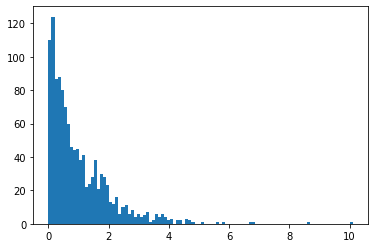

In [10]:
import csv
import matplotlib.pyplot as plt

fileNameRoot="wallets"
rankNum=3

allTheRanks = []

for i in range(rankNum):
    with open(fileNameRoot+str(i)+'.csv', 'r') as file:
        reader = csv.reader(file, delimiter = ',',quoting=csv.QUOTE_NONNUMERIC)
        
        for row in reader:
            allTheRanks = allTheRanks + row
            
#print(allTheRanks)
plt.hist(allTheRanks, 100);